# Práctica 2

## Preparación del entorno

In [1]:
# Librerias
import tensorflow as tf
import keras as ker
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Rescaling


### Variables a definir

In [2]:
# Variables
# No tocar
num_clases = 26
# La foto es 128x96
xpixel = 128
ypixel = 96
# Tocar
n_neuronas_conv1 = 64
n_neuronas_conv2 = 128
n_neuronas_conv3 = 256
l_rate = 0.001  # empezar en 0.001 e ir bajando para el estudio
epoch = 5
batch = 16  # Realmente en 1 esta bien esto es mas para tiempos de ejecucion con grandes cantidades de datos

## Preprocesamiento de datos

### Creación de los dataset

Explicación

In [3]:
def meterdatos():
    directorio = r'../Dataset/'
    df = pd.read_csv(directorio + 'driver_imgs_list.csv')
    # Mezclamos los datos muy importante
    df = df.sample(frac=1)
    fotos = df['img'].values
    conductores = df['subject'].values
    clases = df['classname'].values
    # lo de rutas es magico la vd jejejejej
    rutas = clases + '/' + fotos
    dataset = pd.DataFrame([rutas , conductores])

    imagenesv = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        ) #Aqui podemos hacer augmentation

    
    datasetEntero = dataset.T
    datasetEntero.columns = ['fotos','conductores'] #que sino no  sabe que cojer xcol e ycol
 
    directorio2 = r'../Dataset/imgs/train/'

    entrenamiento = imagenesv.flow_from_dataframe(
        dataframe=datasetEntero,
        directory=directorio2,
        x_col="fotos",
        y_col="conductores",
        batch_size=batch,
        class_mode="categorical",
        target_size=(xpixel,ypixel),
        subset='training'
        
    )
    validacion = imagenesv.flow_from_dataframe(
        dataframe=datasetEntero,
        directory=directorio2,
        x_col="fotos",
        y_col="conductores",
        batch_size=batch,
        class_mode="categorical",
        target_size=(xpixel,ypixel),
        subset='validation'
    )

    return entrenamiento,validacion


In [5]:
def meterdatosaug():
    directorio = r'../Dataset/'
    df = pd.read_csv(directorio + 'driver_imgs_list.csv')
    # Mezclamos los datos muy importante
    df = df.sample(frac=1)
    fotos = df['img'].values
    conductores = df['subject'].values
    clases = df['classname'].values
    # lo de rutas es magico la vd jejejejej
    rutas = clases + '/' + fotos
    dataset = pd.DataFrame([rutas , conductores])

    imagenesv = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=30, 
        zoom_range= [0.2 , 0.4],
        fill_mode='nearest',
        brightness_range = [0.2, 0.6]
        
        ) #Aqui podemos hacer augmentation

    
    datasetEntero = dataset.T
    datasetEntero.columns = ['fotos','conductores'] #que sino no  sabe que cojer xcol e ycol
 
    directorio2 = r'../Dataset/imgs/train/'

    entrenamiento = imagenesv.flow_from_dataframe(
        dataframe=datasetEntero,
        directory=directorio2,
        x_col="fotos",
        y_col="conductores",
        batch_size=batch,
        class_mode="categorical",
        target_size=(xpixel,ypixel),
        subset='training'
        
    )
    validacion = imagenesv.flow_from_dataframe(
        dataframe=datasetEntero,
        directory=directorio2,
        x_col="fotos",
        y_col="conductores",
        batch_size=batch,
        class_mode="categorical",
        target_size=(xpixel,ypixel),
        subset='validation'
    )

    return entrenamiento,validacion


## Creación de la Red

La siguiente red es la red que hemos considerado en la memoria que era la más óptima y la que hemos usado para el entrenamiento y la clasificación.

In [6]:
def Modelar_red(n_conv1, n_conv2, n_conv3, x, y, lr): 
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    # Capas convolucionales
    model.add(MaxPooling2D())
    #   >este bloque se puede seguir añadiendo, quiza con menos neuronas, o menos capas convolucionales, pongo dos por dar un ejemplo nada mas
    # (3,3) es mucho se recomienda unsar 1x1 cuando las img no son mayores de 128x128 la nuestra es 128x96
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    # model.add(Dropout(0.2)) # dropout

    model.add(MaxPooling2D())
   # model.add(Conv2D(n_conv3,(3,3),activation='relu',padding='same'))                                       #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))  # red fully-connected
    model.add(Dense(1024/2, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

## Entrenamiento de la red

Con la red ya creada, es el momento de realizar el entrenamiento. Primero de todo realizamos un callback para parar pronto si no cumple con el objetivo de un los mínimo de 0.2 (puesto que así esta matizado en el enunciado de la práctica). Es decir, se deja de entrenar cuando una métrica monitoreada haya dejado de mejorar. En este caso es el loss con el mínimo de 0.2.

Respecto a las entradas de la función son las siguientes: (modelo de red, datos entrenamiento, datos validacion, epoch, batch)

In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <= 0.2):
            self.model.stop_training = True

def Entrenar(m, e, v, epo, b):
    # Para parar segun el criterio de la pr
    elcallback = myCallback()
    
    history = m.fit(
        e,
        validation_data=v,
        epochs=epo,
        batch_size=b,
        verbose=1,  # Esto te imprime un progress bar con informacion
        shuffle=True,
        callbacks= elcallback
    )
    return history

## Evaluación de la red

El último paso entonces es la evaluación de la red, lo que nos permitirá saber si esta ha sido correctamente diseñada.

In [8]:
def Evaluar(m, e_test):
    return m.evaluate(e_test,verbose=1)

## Preparación para entrenar

En la siguiente celda, ya con todas las funciones creadas procedemos a la ejecución de la creación de los set de datos y de la creación de la red

In [10]:
train, validation = meterdatos()
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red(16,32,64,xpixel, ypixel, l_rate)

Found 17940 validated image filenames belonging to 26 classes.
Found 4484 validated image filenames belonging to 26 classes.


## Ejecución

Una vez tenemos tanto la red como los datos, la entrenamos

Epoch 1/5
1122/1122 [==============================] - 88s 77ms/step - loss: 0.0847 - accuracy: 0.9776 - val_loss: 1.6476e-04 - val_accuracy: 1.0000


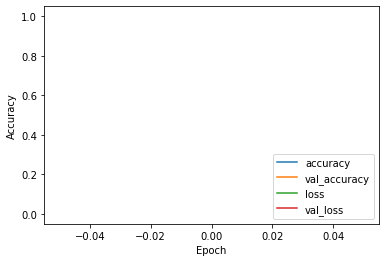

In [11]:
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Evaluación

Evaluamos nuestro modelo

In [12]:
train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

281/281 [==============================] - 17s 60ms/step - loss: 1.6476e-04 - accuracy: 1.0000


## Test

A continuación predecimos 10 imagenes de test, nunca usadas y de cada clase y vemos si son válidas

In [13]:
"""
Como bien hemos comentado, en este caso haremos dos partes procesando 26 imagenes
    - Las tres categorías en las que con mayor probabilidad la imagen es clasificada por la red, en orden 
    descendente de probabilidad 
    - La imagen pintada
Le damos pues 26 imágenes, una de cada tipo 
"""
def buscar_prediccion(prediccion): # Saber que predicción es
    texto_prediccion = ""
    diccionario = {
        0: "p002",
        1: "p012",
        2: "p014",
        3: "p015",
        4: "p016",
        5: "p021",
        6: "p022",
        7: "p024",
        8: "p026",
        9: "p035",
        10: "p039",
        11: "p041",
        12: "p042",
        13: "p045",
        14: "p047",
        15: "p049",
        16: "p050",
        17: "p051",
        18: "p052",
        19: "p056",
        20: "p061",
        21: "p064",
        22: "p066",
        23: "p072",
        24: "p075",
        25: "p081"
    }

    primero = np.where(prediccion == np.amax(prediccion))
    pos1 = prediccion[primero]
    prediccion[primero] = -1
    texto_prediccion1 = str(diccionario[primero[0][0]]) + " " + str(pos1[0]) + "% // "

    segundo = np.where(prediccion == np.amax(prediccion))
    pos2 = prediccion[segundo]
    prediccion[segundo] = -1
    texto_prediccion2 = str(diccionario[segundo[0][0]]) + " " + str(pos2[0]) + "% // "

    tercero = np.where(prediccion == np.amax(prediccion))
    pos3 = prediccion[tercero]
    texto_prediccion3 = str(diccionario[tercero[0][0]]) + " " + str(pos3[0]) + "%"

    texto_prediccion = texto_prediccion1 + texto_prediccion2 + texto_prediccion3

    return texto_prediccion

def pintar_test(red, v): # Esto nos pinta las predicciones
    rows = 20
    columns =1

    predicciones = red.predict(v)
    predicciones *= 100
    
    fig = plt.figure(figsize=(55, 55))

    for i in range(20):
        prediccion = predicciones[i]
        texto_prediccion = buscar_prediccion(prediccion)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(v[i][0][0])
        plt.axis("off")
        plt.title(texto_prediccion)
            

# Creación del csv. Como son 3.4GB de fotos de test no se adjunta las imágenes en el entregable pero
# este es el código que hemos usado para crear el csv

def csv_test(red, v): 
    
    predicciones = red.predict(v,verbose = 1)
    predicciones = predicciones * 100
    
    # Añadimos las predicciones
    df = pd.DataFrame(predicciones, columns = ["p002","p012","p014","p015","p016",
    "p021","p022","p024","p026","p035","p039","p041","p042","p045","p047","p049",
    "p050","p051","p052","p056","p061","p064","p066","p072","p075","p081"])

    df.to_csv('resultados_test.csv')

pintar_test(model, validation)
csv_test(model, validation)

NameError: name 'np' is not defined

<Figure size 3960x3960 with 0 Axes>

## Estudio de otras arquitecturas de red

### Estudio de convolución y pooling

A continuación estudiaremos 4 arquitecturas de red sin dropout para ver cuales es la mejor arquitectura respecto a número de capas de convolución y pooling

In [ ]:
def Modelar_red_1(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    # Capas convolucionales
    model.add(MaxPooling2D())
    #   >este bloque se puede seguir añadiendo, quiza con menos neuronas, o menos capas convolucionales, pongo dos por dar un ejemplo nada mas
    # (3,3) es mucho se recomienda unsar 1x1 cuando las img no son mayores de 128x128 la nuestra es 128x96
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    # model.add(Dropout(0.2)) # dropout

    model.add(MaxPooling2D())
   # model.add(Conv2D(n_conv3,(3,3),activation='relu',padding='same'))                                       #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
def Modelar_red_2(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
def Modelar_red_3(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    model.add(MaxPooling2D())
    # capas convolucionales concatenadas
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
def Modelar_red_4(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))
    model.add(Conv2D(n_conv3*2, (3, 3), activation='relu', padding='same'))    # lo multiplico por 4 para que aumente la profundidad                               
    model.add(Conv2D(n_conv3*4, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

### Estudio de influencia de MLP

A continuación estudiaremos 2 arquitecturas de red para ver cuales es la mejor arquitectura respecto al número de neuronas de MLP

In [ ]:
def Modelar_red_5(n_conv1, n_conv2, n_conv3, x, y, lr): # red original con los valores de MLP cambiados
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    # Capas convolucionales
    model.add(MaxPooling2D())
    #   >este bloque se puede seguir añadiendo, quiza con menos neuronas, o menos capas convolucionales, pongo dos por dar un ejemplo nada mas
    # (3,3) es mucho se recomienda unsar 1x1 cuando las img no son mayores de 128x128 la nuestra es 128x96
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    # model.add(Dropout(0.2)) # dropout

    model.add(MaxPooling2D())
   # model.add(Conv2D(n_conv3,(3,3),activation='relu',padding='same'))                                       #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))  # red fully-connected
    model.add(Dense(32/2, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
def Modelar_red_6(n_conv1, n_conv2, n_conv3, x, y, lr): # red original con los valores de MLP cambiados
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    # Capas convolucionales
    model.add(MaxPooling2D())
    #   >este bloque se puede seguir añadiendo, quiza con menos neuronas, o menos capas convolucionales, pongo dos por dar un ejemplo nada mas
    # (3,3) es mucho se recomienda unsar 1x1 cuando las img no son mayores de 128x128 la nuestra es 128x96
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    # model.add(Dropout(0.2)) # dropout

    model.add(MaxPooling2D())
   # model.add(Conv2D(n_conv3,(3,3),activation='relu',padding='same'))                                       #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))  # red fully-connected
    model.add(Dense(1024/2, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
def Modelar_red_7(n_conv1, n_conv2, n_conv3, x, y, lr): # red original con los valores de MLP cambiados
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    # Capas convolucionales
    model.add(MaxPooling2D())
    #   >este bloque se puede seguir añadiendo, quiza con menos neuronas, o menos capas convolucionales, pongo dos por dar un ejemplo nada mas
    # (3,3) es mucho se recomienda unsar 1x1 cuando las img no son mayores de 128x128 la nuestra es 128x96
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    # model.add(Dropout(0.2)) # dropout

    model.add(MaxPooling2D())
   # model.add(Conv2D(n_conv3,(3,3),activation='relu',padding='same'))                                       
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))  # red fully-connected
    model.add(Dense(4096/2, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

### Estudio de dropout

A continuación estudiaremos las 4 primeras arquitecturas de red con dropout para ver cuales es la influencia del dropout

In [ ]:
def Modelar_red_1_D(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    # Capas convolucionales
    model.add(MaxPooling2D())
    #   >este bloque se puede seguir añadiendo, quiza con menos neuronas, o menos capas convolucionales, pongo dos por dar un ejemplo nada mas
    # (3,3) es mucho se recomienda unsar 1x1 cuando las img no son mayores de 128x128 la nuestra es 128x96
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2)) # dropout

    model.add(MaxPooling2D())
   # model.add(Conv2D(n_conv3,(3,3),activation='relu',padding='same'))                                       #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
def Modelar_red_2_D(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
def Modelar_red_3_D(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    model.add(MaxPooling2D())
    # capas convolucionales concatenadas
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
def Modelar_red_4_D(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(n_conv3*2, (3, 3), activation='relu', padding='same'))    # lo multiplico por 4 para que aumente la profundidad                               
    model.add(Conv2D(n_conv3*4, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
def Modelar_red_4_DPlus(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))

    model.add(Conv2D(filters=n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.6))

    model.add(Conv2D(n_conv3*2, (3, 3), activation='relu', padding='same'))    # lo multiplico por 4 para que aumente la profundidad                               
    model.add(Conv2D(n_conv3*4, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.6))
    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
def Modelar_red_4_DExce(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu' , input_shape=(x, y, 3)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.9))
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.9))

    model.add(Conv2D(n_conv3*2, (3, 3), activation='relu', padding='same'))    # lo multiplico por 4 para que aumente la profundidad                               
    model.add(Conv2D(n_conv3*4, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.9))
    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

## Pruebas de diferentes redes

Una vez tenemos todas las posibles redes, las entrenamos y evaluamos para ver su output

## Estudio arquitecturas

### Red 1

3 capas de convolución con su respectivo pooling cada una. Por último, un MPL de 128 y 64 neuronas respectivamente.

In [ ]:
model = Modelar_red_1(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

Con dropout

In [ ]:
model = Modelar_red_1_D(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

### Red 2

3 capas de convolución seguidas con un único pooling al final. Por último, un MPL de 128 y 64 neuronas respectivamente.

In [ ]:
model = Modelar_red_2(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

Con dropout

In [ ]:
model = Modelar_red_2_D(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

### Red 3

3 capas de convolución, con un pooling en la 1º y 3º capa de convolución. Por último, un MPL de 128 y 64 neuronas respectivamente.

In [ ]:
model = Modelar_red_3(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

Con dropout

In [ ]:
model = Modelar_red_3_D(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

### Red 4

5 capas de convolución, con un pooling en la 1º, 3º y 5º capa de convolución. Por último, un MPL de 128 y 64 neuronas respectivamente.

In [ ]:
model = Modelar_red_4(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

Con dropout 0.2

In [ ]:
model = Modelar_red_4_D(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

Con dropout 0.6

In [ ]:
model = Modelar_red_4_DPlus(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

Con dropout 0.9

In [ ]:
model = Modelar_red_4_DExce(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

## Estudio MLP

### Red 5

2^5 neuronal MLP

In [ ]:
model = Modelar_red_5(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

### Red 6

2^10 neuronas MLP

In [ ]:
model = Modelar_red_6(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

## Estudio learning rates

Por último estudiamos el learning rate más adecuado

In [ ]:
l_rates = [0.00001,0.0001,0.001,0.01]

### Gráficas learning rates

In [ ]:
print("Learning rate de", l_rates[0])
model = Modelar_red(16, 32, 64, xpixel, ypixel, l_rates[0])
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model, train)
val_loss, val_acc = Evaluar(model, validation)

In [ ]:
print("Learning rate de", l_rates[1])
model = Modelar_red(16, 32, 64, xpixel, ypixel, l_rates[1])
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model, train)
val_loss, val_acc = Evaluar(model, validation)

In [ ]:
print("Learning rate de", l_rates[2])
model = Modelar_red(16, 32, 64, xpixel, ypixel, l_rates[2])
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model, train)
val_loss, val_acc = Evaluar(model, validation)

In [ ]:
print("Learning rate de", l_rates[3])
model = Modelar_red(16, 32, 64, xpixel, ypixel, l_rates[3])
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model, train)
val_loss, val_acc = Evaluar(model, validation)